<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week10/HAR_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler # <-- 스케일러 import
import math
import os

In [8]:
# --- 1. 설정 및 데이터 전처리 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# !!! 경로 수정 !!!
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset'

# --- (추가) 성능 향상 옵션 ---
USE_SCALING = False     # <-- 입력 데이터 스케일링 적용 여부
USE_BATCH_NORM = True  # <-- 모델 내 배치 정규화 적용 여부

# --- (추가) 하위 폴더 경로 설정 ---
TRAIN_PATH = os.path.join(DATA_PATH, 'train/')
TEST_PATH = os.path.join(DATA_PATH, 'test/')

Using device: cuda


In [9]:
# --- 데이터 로딩 함수 (공통) ---
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep=r'\s+')
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = os.path.join(prefix, group, 'Inertial Signals/')
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(os.path.join(prefix, group, 'y_'+group+'.txt'))
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix)
    testX, testy = load_dataset_group('test', prefix)
    trainy = trainy - 1
    testy = testy - 1
    print(f"trainX shape: {trainX.shape}, trainy shape: {trainy.shape}")
    print(f"testX shape: {testX.shape}, testy shape: {testy.shape}")
    return trainX, trainy, testX, testy

# --- 학습/평가 함수 (공통) ---
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc.item()

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc.item()

def get_test_results(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(6), yticklabels=range(6))
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [10]:
# --- 모델 2: LSTM ---
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, use_bn=False):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.use_bn = use_bn

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=0.2)

        if self.use_bn:
            # LSTM 출력 (N, hidden_dim)에 적용할 1D 배치정규화
            self.bn = nn.BatchNorm1d(hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (N, L, C) - batch_first=True
        _, (h_n, _) = self.lstm(x)
        out = h_n[-1, :, :]

        if self.use_bn:
            out = self.bn(out) # (N, hidden_dim)

        out = self.fc(out)
        return out

In [11]:
# --- 메인 실행 ---
def main():
    # 데이터 로드
    trainX, trainy, testX, testy = load_dataset(DATA_PATH)

    # (추가) 스케일링 적용
    if USE_SCALING:
        print("Applying StandardScaler...")
        n_samples_train, n_timesteps, n_features = trainX.shape
        n_samples_test = testX.shape[0]

        trainX_2d = trainX.reshape(-1, n_features)
        scaler = StandardScaler()
        scaler.fit(trainX_2d)

        trainX_scaled_2d = scaler.transform(trainX_2d)
        testX_2d = testX.reshape(-1, n_features)
        testX_scaled_2d = scaler.transform(testX_2d)

        trainX = trainX_scaled_2d.reshape(n_samples_train, n_timesteps, n_features)
        testX = testX_scaled_2d.reshape(n_samples_test, n_timesteps, n_features)
        print("Scaling complete.")

    # Keras의 validation_split=0.1과 유사하게 0.1로 변경
    X_train, X_val, y_train, y_val = train_test_split(
        trainX, trainy, test_size=0.1, random_state=42, stratify=trainy
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.flatten(), dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.flatten(), dtype=torch.long)
    X_test_tensor = torch.tensor(testX, dtype=torch.float32)
    y_test_tensor = torch.tensor(testy.flatten(), dtype=torch.long)

    # 하이퍼파라미터
    N_EPOCHS = 40
    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    HIDDEN_DIM = 128
    NUM_LAYERS = 2

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    N_TIMESTEPS = X_train.shape[1]
    N_FEATURES = X_train.shape[2]
    N_OUTPUTS = len(np.unique(trainy))

    # 모델 2 실행
    model_name = "2. LSTM"
    model = LSTMModel(N_FEATURES, HIDDEN_DIM, N_OUTPUTS, NUM_LAYERS,
                      use_bn=USE_BATCH_NORM).to(device)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    criterion = nn.CrossEntropyLoss()

    print(f"\n--- 🏋️ Training {model_name} ---")

    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1:02}/{N_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

    # 테스트셋 평가
    print(f"\n--- 📊 Evaluating {model_name} on Test Set ---")
    y_test_true, y_test_pred = get_test_results(model, test_loader, device)
    test_acc = accuracy_score(y_test_true, y_test_pred)
    print(f"Test Accuracy: {test_acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test_true, y_test_pred, digits=4, zero_division=0))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test_true, y_test_pred)
    print(cm)
    plot_confusion_matrix(cm, model_name)

trainX shape: (7352, 128, 9), trainy shape: (7352, 1)
testX shape: (2947, 128, 9), testy shape: (2947, 1)

--- 🏋️ Training 2. LSTM ---
Epoch 01/40 | Train Loss: 0.7991 | Train Acc: 0.6706 | Val Loss: 0.4297 | Val Acc: 0.8274
Epoch 02/40 | Train Loss: 0.3734 | Train Acc: 0.8567 | Val Loss: 0.5264 | Val Acc: 0.8383
Epoch 03/40 | Train Loss: 0.2593 | Train Acc: 0.9045 | Val Loss: 0.1951 | Val Acc: 0.9239
Epoch 04/40 | Train Loss: 0.2180 | Train Acc: 0.9229 | Val Loss: 0.2296 | Val Acc: 0.9158
Epoch 05/40 | Train Loss: 0.1890 | Train Acc: 0.9264 | Val Loss: 0.1769 | Val Acc: 0.9280
Epoch 06/40 | Train Loss: 0.1744 | Train Acc: 0.9358 | Val Loss: 0.1115 | Val Acc: 0.9620
Epoch 07/40 | Train Loss: 0.1613 | Train Acc: 0.9392 | Val Loss: 0.1100 | Val Acc: 0.9457
Epoch 08/40 | Train Loss: 0.1674 | Train Acc: 0.9346 | Val Loss: 0.1152 | Val Acc: 0.9429
Epoch 09/40 | Train Loss: 0.1537 | Train Acc: 0.9414 | Val Loss: 0.1472 | Val Acc: 0.9429
Epoch 10/40 | Train Loss: 0.1441 | Train Acc: 0.9432 | 

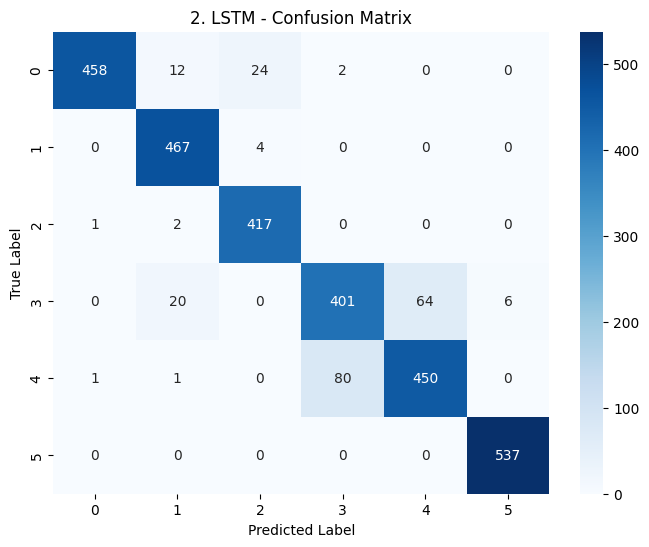

In [12]:
if __name__ == "__main__":
    # 데이터셋 경로가 올바른지 확인
    if not os.path.isdir(DATA_PATH) or not os.path.isdir(os.path.join(DATA_PATH, 'train')):
        print(f"Error: DATA_PATH '{DATA_PATH}'를 찾을 수 없습니다.")
        print("DATA_PATH 변수를 'UCI HAR Dataset' 폴더의 실제 경로로 수정해주세요.")
    else:
        main()